# **Fine-Tuned vs. OpenAI GPT-4o: Quality Evaluation Notebook**

### **About This Notebook:**

This notebook demonstrates inferencing the test dataset using the `OpenAI GPT-4o` API and comparing the results with the `Base Model (No Fine-Tuning)`, `LoRA Fine-Tuning`, and `Full Fine-Tuning` approaches.

We first use the `OpenAI GPT-4o` API to generate answers for user queries with images—these queries and images come from our test dataset. Then, we calculate the `similarity score` for this `OpenAI GPT-4o` API approach. Along with the existing similarity scores from previous model fine-tuning experiments, we plot a side-by-side comparison of the similarity scores for all approaches, using the `Ground Truth` as a reference.

During this process, login and utility functions such as login_hf(), load_processor(), load_model(), load_hf_dataset(), and plot_similarity_scores() can be leveraged from previous model fine-tuning experiments. Hence, to keep things simple, we reuse the entire `my_login.py` and `my_utils.py` files and install all Python libraries as we did in previous fine-tuning experiments, even though only a subset of them is required.

Additionally, since the similarity score calculation (i.e., computing the `contextual embedding distance` between the `Ground Truth` and the `generated answer`) requires loading a base model, we rent an `Nvidia RTX A6000 GPU` for this experiment.

### **Supporting Python and CSV Files:**

This notebook utilizes the following external files:

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face). Created in the [Complete LoRA Fine-Tuning Notebook](../../2_model_finetuning/2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2_model_finetuning/2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_openai.py`: Contains utility functions specifically for running test dataset inference using the `OpenAI GPT-4o` API. Created within this notebook.

- `finetuned_inference_results/inference_results_before_finetuning.csv`: Contains the similarity score of the `Base Model (No Fine-Tuning)`. Created in the [Complete LoRA Fine-Tuning Notebook](../../2_model_finetuning/2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `finetuned_inference_results/inference_results_after_lora_finetuning.csv`: Contains the similarity score of the `LoRA Fine-Tuned Model`. Created in the [Complete LoRA Fine-Tuning Notebook](../../2_model_finetuning/2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `finetuned_inference_results/inference_results_after_full_finetuning.csv`: Contains the similarity score of the `Full Fine-Tuned Model`. Created in the [Full Fine-Tuning Notebook](../../2_model_finetuning/2.4_full_finetuning/run_1_a100_80g_x1/full_finetuning.ipynb).

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 150GB
- `GPU Setup`: 1 Nvidia RTX A6000 GPU (48GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Comparison of Fine-Tuned Models and OpenAI GPT-4o**

## 2.1 Log in to Required Accounts (Hugging Face) 

In [1]:
import my_login
# Log in to the Hugging Face account to access the Idefics2 model and the dataset
my_login.login_hf()

==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## 2.2 Load the Processor (Tokenizer) and the Base Model

In [2]:
import my_utils

# Load processor
processor = my_utils.load_processor()

# Load model
base_model = my_utils.load_model()

==> Loading processor...


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

==> Loading model...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

## 2.3 Load the Dataset

In [3]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

==> Loading hf dataset...


README.md:   0%|          | 0.00/648 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/74 [00:00<?, ? examples/s]

## 2.4 Call OpenAI API to Evaluate the Test Dataset

In [4]:
%%writefile my_utils_openai.py
# --------------- Functions for Making OpenAI API Calls ---------------
# 1) Calculate the cost of API calls based on the number of tokens used
def calculate_token_cost(model, input_token_count=0, output_token_count=0):
    input_token_price = 0
    output_token_price = 0
    # define token prices (dollars per million tokens, price as of Jan 2025) based on the model
    if model == 'gpt-4o':
        input_token_price = 2.5
        output_token_price = 10.0
    elif model == 'gpt-4o-mini':
        input_token_price = 0.15
        output_token_price = 0.6
    # calculate the total cost of API calls
    cost = (input_token_count / 1_000_000 * input_token_price +
            output_token_count / 1_000_000 * output_token_price)
    return round(cost, 2)

# 2) Encode an image to base64 format for OpenAI multi-modal model processing
import base64
import io
def encode_image(image):
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG")  # save the image to an in-memory BytesIO buffer
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

# 3) Send a user query with an image using the OpenAI API 
import requests
import time
def send_user_query_with_image(img_path, user_question, max_retry=5):
    base64_image = encode_image(img_path)
    api_key = 'your OpenAI API key' # replace with your OpenAI API key
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        "model": "gpt-4o",    #latest multi-modal model
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{user_question}"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 1000
    }
    # attempt API call with exponential backoff for throttling handling
    for attempt in range(1, max_retry + 1):
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        if response.status_code == 429: #handle rate limiting with exponential backoff
            wait = 2 ** attempt
            print(f"Retrying in {wait} seconds...", end='')
            time.sleep(wait)
        else:                           #for non-throttling status, go to next step
            break
    if response.status_code == 200:     #successful API response
        response_content = response.json()["choices"][0]["message"]["content"]
        input_tokens = response.json()["usage"]["prompt_tokens"]
        output_tokens = response.json()["usage"]["completion_tokens"]
        return response_content, input_tokens, output_tokens
    else:                               #handle API failures
        print(f'\nAPI call failure: {response.status_code}')
        print(f'API call reponse: {response.json()}')
        return None, 0, 0

# 4) Perform inference on the test dataset using OpenAI API, save image thumbnails, and save inference results to a CSV file
# Note: The saved image thumbnails and the CSV file will be used in plot_similarity_scores() next step
import os
import pandas as pd
import json
import my_utils
def inference_openai(model, processor, dataset, report_csv):
    print(f'==> Performing inference and saving results to {report_csv} ...')

    # Prepare directories for image thumbnails and CSV file
    report_csv_dir = os.path.dirname(report_csv)
    thumbnail_dir = os.path.join(report_csv_dir, 'thumbnail')
    if not os.path.exists(report_csv_dir):
        os.makedirs(report_csv_dir)
    if not os.path.exists(thumbnail_dir):
        os.makedirs(thumbnail_dir)

    report_df = pd.DataFrame(columns=['data_id', 'item_name', 'image_name', 'user_question', 'model_generated_answer', 'ground_truth_answer', 'semantic_similarity_score'])
    accumulated_semantic_similarity_score = 0
    total_input_tokens = 0
    total_output_tokens = 0
    for idx, data in enumerate(dataset):
        print(f'==> [Processing data: {idx + 1}/{len(dataset)}]  data_id: {data["data_id"]}, item_name: {data["item_name"]}, image_name: {data["image_name"]}')
        # Save a thumbnail of the current image
        image = data['image']
        image_resized = data['image'].resize((100, 100))
        thumbnail = data['image'].resize((20, 20))
        thumbnail.save(os.path.join(thumbnail_dir, data["image_name"]))
        # Extract the user question and ground truth answer from the current dialog
        dialog_json = json.loads(data['dialog'])
        user_msg = dialog_json['messages'][0] 
        assistant_msg = dialog_json['messages'][1]
        user_question = user_msg['content'][1]['text']
        ground_truth_answer = assistant_msg['content'][0]['text']
        # Send the user query along with the image to OpenAI API and get the generated response
        generated_answer, input_tokens, output_tokens = send_user_query_with_image(image, user_question)
        total_input_tokens += input_tokens
        total_output_tokens += output_tokens
        total_cost = calculate_token_cost('gpt-4o', total_input_tokens, total_output_tokens)
        # Display the response generated by OpenAI API and evaluate its quality using semantic similarity scores
        semantic_similarity_score = my_utils.calculate_semantic_similarity_score(model, processor, generated_answer, ground_truth_answer)
        image_resized.show()
        print(f'==> Original user question: {user_question}')
        print(f'==> OpenAI GPT-4o generated answer: {generated_answer}')
        print(f'==> Ground truth answer: {ground_truth_answer}')
        print(f'==> Semantic similarity score: {semantic_similarity_score}')
        print(f'==> OpenAI GPT-4o total_tokens: {total_input_tokens}(input), {total_output_tokens}(output), total_cost: ${total_cost}')
        # Save results in the CSV file
        data_df = pd.DataFrame([{'data_id': data['data_id'],
                                    'item_name': data['item_name'],
                                    'image_name': data['image_name'],
                                    'user_question': user_question,
                                    'model_generated_answer': generated_answer,
                                    'ground_truth_answer': ground_truth_answer,
                                    'semantic_similarity_score': semantic_similarity_score.item()}])
        report_df = pd.concat([report_df, data_df], ignore_index=True)
        accumulated_semantic_similarity_score += semantic_similarity_score.item()
    # Calculate and save average similarity score for the dataset
    ave_semantic_similarity_score = round(accumulated_semantic_similarity_score / len(dataset), 3)
    print(f'==> Average semantic similarity score: {ave_semantic_similarity_score} (0 is the best, 2 is the worst)')
    report_df = pd.concat([report_df, pd.DataFrame([{'item_name': 'average_semantic_similarity_score', 'semantic_similarity_score': ave_semantic_similarity_score}])], ignore_index=True)
    report_df.to_csv(report_csv, index=False, encoding='utf-8')

Writing my_utils_openai.py


==> Performing inference and saving results to ./results/inference_results/inference_results_openai_gpt4o.csv ...
==> [Processing data: 1/74]  data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg


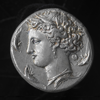

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit appears to be an ancient coin, likely a Greek silver drachma or tetradrachm, featuring a detailed profile of a female figure. The figure has curly hair and is adorned with earrings, suggesting she may represent a deity or a prominent person. The craftsmanship is intricate, typical of classical Greek coinage. Some letters or designs can be seen around the border of the coin.
==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American c

/workspace/3.1_finetuned_vs_openai/my_utils_openai.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


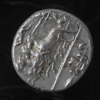

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: The image shows a silver coin with intricate designs. Such coins are often from ancient civilizations and hold historical significance. This particular coin appears to have Greek styling, possibly depicting a deity or symbolic imagery, typical of ancient Greek coinage used for both trade and as a means to convey art or messages. These coins are valuable to numismatists and historians for understanding the culture, economy, and artistry of the period from which they originate. Without additional context regarding the specific exhibit, it's difficult to provide more detailed information.
==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompt

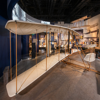

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit showcases a replica of the Wright brothers' 1903 Flyer, the first successful powered aircraft. The plane features a wooden frame and fabric wings, reflecting the design innovations of the early 20th-century aviation pioneers. The exhibit likely includes informational panels and displays about the Wright brothers' groundbreaking work in aeronautics and the historical significance of their first flight. The environment is likely designed to educate visitors on the development of early aviation technology.
==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs l

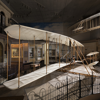

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features the Wright Flyer, the airplane used by the Wright brothers for the first successful powered flights in 1903 at Kitty Hawk, North Carolina. It is displayed at the National Air and Space Museum in Washington, D.C. 

The Wright Flyer was groundbreaking because it was the first powered, heavier-than-air machine to achieve controlled, sustained flight with a pilot aboard. The aircraft utilizes a biplane design with a wingspan of approximately 40 feet and was powered by a custom-built engine. The structure of the plane is made of wood and fabric, showcasing early aviation engineering.

This exhibit is significant as it marks the beginning of the modern aviation era and highlights the ingenuity and pioneering spirit of the Wright brothers.
==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered 

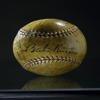

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features a vintage baseball with a signature, likely a collectible piece. The ball has an aged, yellowish appearance with visible stitching. It is displayed on a reflective surface, highlighting its historical significance. The signature is a key feature, indicating it may have belonged to or been signed by a notable baseball figure.
==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illne

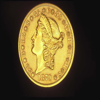

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit features a gold coin with a profile portrait of a woman wearing a diadem or crown. Around the edge of the coin, there are various inscriptions including numeric values and letters: "30 G", "1.5 S", "3.5 C", "35 GRAINS", which likely refer to the coin's specifications such as weight and composition. The date "1879" is prominently displayed at the bottom. Decorative stars and dots are also present around the edges. The design and style suggest it is from the 19th century.
==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but 

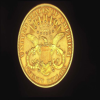

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: The image shows a U.S. twenty-dollar gold coin, known as a Double Eagle. The coin is from the early 20th century, a time when these coins were part of the U.S. currency. The design features an eagle and the words "United States of America" and "Twenty Dollars," along with "E Pluribus Unum" and "In God We Trust," which were common inscriptions on U.S. currency. It's likely part of a numismatic exhibit showcasing historical American coins.
==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This

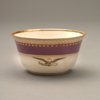

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit is a ceramic cup with a classic design. It features a wide purple band near the rim, adorned with a gold linked chain pattern and a row of gold dots beneath it. Below the band, there is an image of an eagle holding arrows and an olive branch, a symbol often associated with strength and peace. The cup's rim and base are accented with a thin gold line, adding to its elegant appearance.
==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Tay

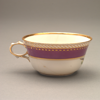

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a porcelain cup attributed to the Doccia Porcelain Factory, dating from around 1800. It's made of porcelain and features decorative elements in purple and gold, including an intricate design near the rim. The cup is part of the collection at the RISD Museum in Rhode Island, USA. The Doccia Porcelain Factory, founded in the 18th century in Italy, is well-known for its finely crafted porcelain pieces.
==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful nig

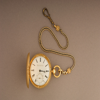

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features an intricate golden pocket watch with a cover, attached to an elegant chain. The watch face has Roman numerals and slender hour and minute hands, with an additional smaller dial for seconds. The gold chain is ornately linked and includes a decorative hook for attachment. The design suggests it is a classic, antique timepiece, showcasing fine craftsmanship and timeless elegance.
==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one 

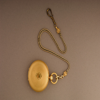

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features an intricately designed pocket watch with a matching chain. The watch and chain are crafted from what appears to be gold, exhibiting a luxurious and elegant design. Pocket watches like this were popular in the 19th and early 20th centuries and often represented wealth and status. The chain is likely a fob, used to attach the watch to clothing, preventing it from being dropped or stolen. The detailed embellishments suggest it might be a piece of fine craftsmanship, possibly from a renowned watchmaker of that era.
==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at th

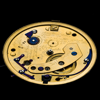

==> Original user question: Could you provide an overview of what is on display here?
==> OpenAI GPT-4o generated answer: This is an image of the inner workings of a pocket watch, specifically showing its movement and components. The movement includes gears, screws, and other parts typical of mechanical watches. There are engraved inscriptions, which suggest historical significance. Such watches often have engravings for personalization or to commemorate events, reflecting the craftsmanship and engineering of the time.
==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiec

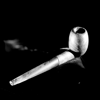

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit shown is a black and white photograph of a smoking pipe. It has a traditional shape with a rounded bowl and a straight stem. The pipe is positioned on a dark surface, and is dramatically lit to highlight its contours and texture. The image emphasizes the classic and timeless design of the pipe.
==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein,

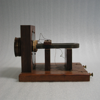

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit is an early version of an electric motor. It has a simple and rudimentary design, consisting of a large coil mounted on a wooden base with metal support structures. The coil is attached to a rod and connected with wires, likely for conducting electricity to generate motion. This setup represents an important step in the development of electric motors, demonstrating the principles of electromagnetism and motion.
==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of t

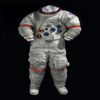

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a space suit, specifically, an Apollo A7L suit used by NASA during the Apollo missions to the Moon. The suit is white with red details, including horizontal rings on the arms and legs, designed for visibility. The front of the suit features various connectors for life support systems. An American flag is visible on the shoulder. These suits were designed to protect astronauts from the extreme conditions of space.
==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed 

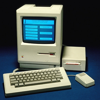

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit shows an Apple Macintosh computer from the 1980s. This classic model features an integrated CRT monitor with a disk drive beneath it. The setup includes a separate keyboard and a one-button mouse. Its design is compact and minimalist, typical of early Apple computers, and it likely displays a simple graphical user interface. The Macintosh was known for its user-friendly interface and pioneering influence on personal computing.
==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a ret

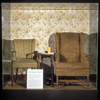

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features a pair of chairs known as "The Bunkers' Chairs," likely from a television show or cultural setting. The chairs are displayed against a floral wallpaper backdrop. The one on the left is an armchair with a patterned fabric, and the one on the right is a larger, upholstered chair with a more traditional design. A small wooden table sits between them, holding a mug and a small dish, contributing to a domestic, cozy atmosphere. The exhibit plaque provides some information about the significance of the chairs.
==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain 

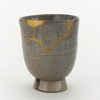

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit showcases a piece of pottery repaired using the Japanese art of Kintsugi. Kintsugi is a technique where broken ceramics are repaired with lacquer mixed with powdered gold, silver, or platinum. The visible seams highlight the fractures, celebrating the object's history rather than concealing the damage. This specific piece shows the characteristic golden lines of Kintsugi, emphasizing its aesthetic and philosophical appreciation for imperfection and resilience.
==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This 

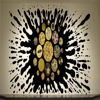

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit features a striking large-scale wall artwork with a dynamic black paint splatter design. Within the splatter are various circular elements showcasing intricate patterns and motifs. These circles contain diverse designs such as floral, geometric, and abstract patterns in a palette of gold, red, and other complementary colors, creating a rich contrast against the black background. The overall effect is bold and energetic, drawing the viewer's attention to the interplay of color, pattern, and form.
==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutc

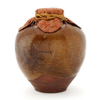

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit is a traditional Japanese tea jar made of ceramic. It features a round body with a narrow base, and the surface has a rustic, speckled glaze that gives it a textured appearance. The jar is covered with a cloth, likely silk or another fine material, in a reddish-brown color with a subtle pattern. The cloth is secured with an ornamental cord tied into a decorative knot. This type of jar is often used in the Japanese tea ceremony to store powdered tea.
==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named C

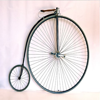

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a classic penny-farthing bicycle, also known as a high wheel. It features an oversized front wheel and a much smaller rear wheel. These bicycles were popular in the late 19th century. The large front wheel allowed for greater speed and a smoother ride over uneven surfaces, but they were more challenging to ride due to the high center of gravity. The design is iconic and often seen in historical representations of early cycling.
==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported

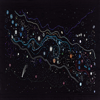

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit appears to be a textile artwork, possibly a quilt, featuring an intricate cosmic or celestial theme. The piece is set against a black background and is adorned with various patterns that resemble stars, galaxies, and cosmic elements. There are swirling lines and shapes, with colors including blues, purples, and whites, adding to the celestial appearance. The use of embellishments like beads or embroidery adds texture and depth, creating a vibrant depiction of a starry sky or universe.
==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's wor

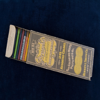

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit shows a vintage box of Binney & Smith Co. "Crayola" crayons. The box advertises "28 Assorted Colors" and is designed for "Young Artists" and uses "No. 51" as its designation. The text on the box highlights its use for "Coloring Maps, Pictures, &c." The crayons inside the box are arranged in rows, showcasing a variety of colors. The design and typography suggest this is an older edition, likely from the early 20th century.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous

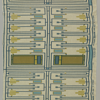

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a textile design titled "Design 105" by Arnold Truen, created in 1954. It features a geometric pattern with vertical and horizontal lines creating rectangular shapes. The design incorporates a color palette of beige, olive green, blue, and a touch of mustard yellow. The pattern has a structured and modern feel, reminiscent of mid-century design aesthetics. The text along the side indicates it's an exclusive hand print using vat colors.
==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white b

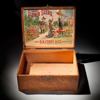

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a vintage wooden box labeled with "CHOICE FLOWER SEEDS" from D.M. Ferry & Co., Detroit, Mich. The inside lid features a colorful, nostalgic illustration of people tending to a vibrant flower garden. The exterior of the box is simple, with a decorative metal clasp. The overall design suggests it was used for storing or displaying flower seeds, likely from the late 19th or early 20th century, reflecting the period's style and advertising techniques.
==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which 

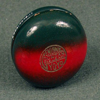

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This is an image of a vintage Duncan yo-yo. It has a two-tone color design, with a dark green and red gradient. The words "Genuine Duncan Yo-Yo" are printed on it. Duncan is a well-known brand for yo-yos, often recognized for their quality and classic designs.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demonstrations to attract buyers. Duncan, an astut

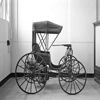

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit showcases an early horseless carriage, likely one of the first models of gasoline-powered vehicles. It features a simple open-air design with large, spoke wheels typical of the transition from horse-drawn carriages to motor vehicles. The carriage has a single seat for the driver, a small step for entry, and a canopy to provide some protection from the elements. The overall design reflects the early days of automotive innovation, where elements of both carriages and early automobiles are evident.
==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financ

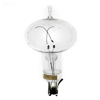

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is an early incandescent light bulb with an intricate structure. It features a large, clear glass bulb with a distinctive rounded top. Inside, you can see two filament supports. The design is characteristic of early electrical lighting technology, reflecting the innovation in electric lighting from the late 19th to early 20th century. The bulb appears to be mounted on a base, possibly for display purposes.
==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense t

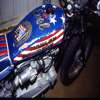

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit showcases a Harley Davidson motorcycle with a distinctly patriotic theme. The fuel tank is decorated with an American flag design, featuring stars and stripes. There is an emblem or patch with a flag design on it as well. The seat has a red, white, and blue color scheme, complementing the overall American theme. The motorcycle has a vintage and well-used appearance, with some visible wear and patina, adding to its character.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginn

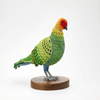

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a detailed sculpture of a bird, covered in an intricate crochet design. The bird itself appears to be made of a smooth material, possibly metal or plastic, painted in vibrant colors. The crochet work features a mix of green, yellow, and orange hues, creating a textured, cozy appearance. The bird is mounted on a wooden base, giving it a polished, artistic display.
==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such a

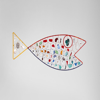

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is an art installation resembling the shape of a fish. It's constructed from a wire frame that outlines the fish's body, with sections of the frame colored in red, yellow, and blue. Inside the fish shape, various small, colorful objects are suspended within a mesh-like structure. These objects appear to be made of different materials and include various shapes and colors, contributing to a playful and abstract aesthetic. The arrangement is visually engaging and suggests a whimsical interpretation of a fish.
==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him

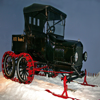

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit shows a modified early 20th-century automobile, likely a Ford Model T, equipped for snow travel. The vehicle features tire chains on the rear wheels and skis in place of front wheels, allowing it to travel over snow. The vehicle is black with a canopy top and has "R.F.D. Route 2" painted on the side, indicating it may have been used for rural mail delivery. The exhibit is set on a display of artificial snow, highlighting its use in winter conditions.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with sk

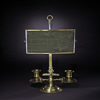

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit is a brass candle stand from around 1750-1800. It features a central vertical pole supporting a rectangular screen, likely intended to shield light or heat. There are two candle holders extending horizontally from the central pole, with a balanced base for stability. The design reflects the functional and decorative style typical of that period.
==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United Stat

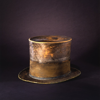

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features a well-worn, historical top hat. The hat shows clear signs of age, with a faded appearance and worn fabric. Its cylindrical crown and broad brim are typical of a traditional top hat design. The hat's distressed condition suggests it may have historical significance or belonged to a notable figure, often found in museum collections dedicated to historical artifacts.
==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fatefu

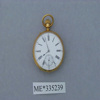

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is an antique pocket watch with a classic design. It features a white dial with black Roman numerals for hour markers and a smaller subdial for seconds. The case appears to be made of gold or gold-toned metal, giving it a vintage and elegant appearance. The watch has a loop at the top for attaching a chain. There is a label with "ME*335239" in front of the watch, possibly indicating a catalog or exhibit number.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," g

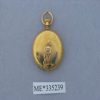

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit appears to be a vintage or antique pocket watch. It's a gold-colored timepiece with intricate detailing on the case. Pocket watches like this were popular in the 19th and early 20th centuries and often featured ornate designs. The number "ME*335239" likely refers to its catalog or accession number in a museum or collection. This kind of watch might have historical or artistic significance, reflecting the craftsmanship of the era in which it was made.
==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 18

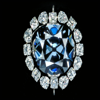

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features a large, stunning blue gemstone, possibly a sapphire or a blue diamond, set at its center. The central stone is surrounded by rows of clear, sparkling diamonds, creating a striking contrast with its rich blue hue. The arrangement and design suggest it's likely part of a high-end jewelry piece, such as a brooch or pendant, emphasizing elegance and opulence. The stones are all cut in refined geometric shapes, enhancing their brilliance and beauty.
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category a

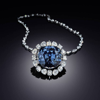

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This image shows the Hope Diamond, a famous gemstone known for its striking blue color. Weighing 45.52 carats, it is one of the most famous jewels in the world. The diamond's blue color is due to trace amounts of boron within its crystal structure. It has a storied history, dating back several centuries, and has passed through numerous owners, including royalty. The diamond is part of the Smithsonian Institution's collection and is displayed at the National Museum of Natural History in Washington, D.C. Its supposed "curse" and fascinating past have intrigued gem enthusiasts and historians alike.
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintag

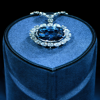

==> Original user question: Could you provide an overview of what is on display here?
==> OpenAI GPT-4o generated answer: This is an image of a famous piece of jewelry known as the Hope Diamond. It is a large, deep blue diamond surrounded by smaller white diamonds, set in a pendant necklace. The display emphasizes its distinct color, size, and brilliance, often highlighted in exhibitions due to its historical significance and allure.
==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in-depth in

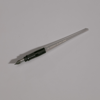

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit is a fountain pen with a clear and black body. The pen has "THE PRESIDENT—THE WHITE HOUSE" printed on it, indicating it could be a pen used for official Presidential purposes. The design is minimalistic, featuring a metal nib and a simple cylindrical shape. This type of pen is often used for signing important documents due to its formality and historical significance.
==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially intr

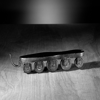

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit appears to be a vintage roller skate. It features a metal base with five wheels arranged in a single line. There's a hook-like structure at one end, possibly used for attaching or adjusting the skate to a shoe. The design suggests an older style, likely from when roller skates were more simplistic in construction compared to modern designs.
==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller a

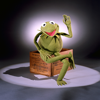

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features a well-known green puppet character sitting on a vintage wooden crate labeled "W. Baker & Co." The puppet has a friendly expression, characterized by large eyes and a wide mouth, and is posed with one arm raised in a wave. The background is set against a spotlight that highlights the character, emphasizing its vibrant green color and friendly demeanor. The crate underscores a sense of nostalgia and classic charm.
==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of 

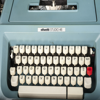

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features an Olivetti Studio 46 typewriter. Olivetti, an Italian company, was known for producing stylish and reliable typewriters in the mid-20th century. The Studio 46 is a mechanical typewriter, notable for its robust design and smooth typing action. It likely dates back to the 1970s, a period when Olivetti was a leading innovator in typewriter technology.

Its features typically include:

- QWERTY keyboard layout
- Manual carriage return
- Durable construction ideal for heavy use

This typewriter is a classic example of mid-century industrial design, combining functionality with aesthetic appeal.
==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also kno

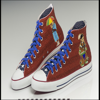

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit showcases a pair of custom beaded high-top sneakers. The shoes feature intricate beadwork on a red background. One shoe displays a figure in traditional attire holding an umbrella, while the other shoe has a figure wearing traditional Native American clothing with feathered accessories. Both shoes have blue laces, a white rubber toe cap, and soles, with star accents near the toe area. The detailed beadwork highlights cultural themes and craftsmanship.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the ric

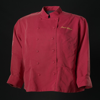

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a red chef's jacket featuring a mandarin collar and double-breasted design, with the name "Leah Chase" embroidered on the left chest in gold lettering. The jacket has long sleeves with folded cuffs, and the buttons are the same color as the fabric.
==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mothe

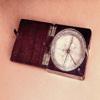

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This is an image of a historical compass placed inside a wooden case. The case has hinges, allowing it to open like a book. The compass face has directional markings, including cardinal and intercardinal points. The compass needle is centrally mounted and points towards the magnetic north. The overall appearance suggests that this is an antique or vintage navigational instrument.
==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedit

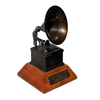

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This is a Grammy Award trophy. The trophy is in the shape of a gramophone, with a horn-like speaker mounted on a wooden base. The Grammy is a prestigious music award presented by the National Academy of Recording Arts and Sciences, recognizing achievements in the music industry. The design reflects the historical significance of sound recording.
==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the 

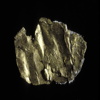

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit shows a gold nugget. It appears to be a natural fragment of gold, displaying its metallic luster and uneven, rugged texture. The nugget has an irregular shape, typical of naturally occurring gold found in riverbeds or mines. Its surface appears to have some texture and possibly small indentations. This nugget could serve as a specimen in a mineral or geology exhibit, showcasing natural precious metals.
==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this

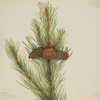

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features a detailed watercolor painting of a pine branch. The painting highlights the slender, green pine needles and a cluster of brown pine cones. The artist has used precise brushstrokes to capture the texture and natural details of the needles and cones. In the lower left corner, there's text indicating initials and a location or event, possibly "Clearwater Camp" with a date marked as 1921. The background is a blank, off-white canvas that emphasizes the botanical subject.
==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint

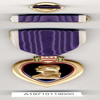

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit displays the Purple Heart medal, an American military decoration. The medal is heart-shaped with a gold border, featuring a purple background. In the center, there's a profile of George Washington. Above the heart is a shield and green leaves emblem. The ribbon is purple with white edges, and the exhibit includes the medal itself as well as its ribbon bar and ribbon mount. The label below the medal reads "A19710119000."
==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse

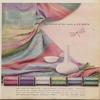

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit is an advertisement for Lurex, highlighting its use in decorative fabrics. It features a draped textile with soft pastel colors like pink, purple, blue, and green, woven with Lurex for a metallic shimmer. In front of the fabric is a white porcelain vase and bowl, enhancing the theme of elegance and subtle shine. A dragonfly illustration is included, adding a delicate touch. Spools of Lurex thread are displayed at the bottom, emphasizing the variety of available colors. The text highlights the association with porcelain-like qualities and mentions designer Dorothy Liebes.
==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Lieb

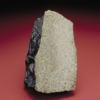

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This image shows a piece of the Nakhla meteorite. The exhibit likely highlights its significance as a Martian meteorite, which fell in Egypt in 1911. The meteorite is notable for its smooth, fusion-crusted surface and the rough, lighter-colored interior, which is visible due to the cut or break. The Nakhla meteorite is famous for the story of hitting a dog and has been studied for clues about Mars's geology and potential past life.
==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smit

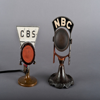

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit features two vintage microphones, each associated with major American broadcasting networks. On the left is a microphone with the "CBS" logo, designed with a triangular nameplate and a simple, sturdy base. On the right is a microphone bearing the "NBC" logo, characterized by a more ornate base and a circular windscreen. Both microphones represent the era of early radio broadcasting, highlighting the iconic styles and branding of the networks.
==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhi

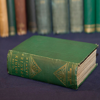

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit features a book titled "On the Origin of Species" by Charles Darwin. It is an important work in scientific literature, first published in 1859. The book is bound in a green cover with gold lettering on the spine. It is displayed on a dark surface against a backdrop of other books.
==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-year expedit

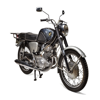

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The image shows a vintage motorcycle, likely a classic Honda model from the 1960s, such as a Honda CB series bike. It features a chrome and black design with a prominent round headlight, twin exhaust pipes, and a minimalist seat. The bike has a classic, sturdy frame with spoked wheels, giving it a retro and utilitarian look. The engine and mechanical components are exposed, typical of motorcycles from this era. The overall design reflects the iconic style and engineering of mid-20th century motorcycles.
==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974,

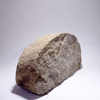

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a large, roughly hewn stone. It appears to have an uneven, textured surface with a grayish color, hinting at its possible geological origin. The shape is somewhat rectangular, with flat and angular sides, suggesting it may have been shaped or altered by human activity. This exhibit could be part of a geological, historical, or archaeological display, but specific details about its origin or significance would be needed for further context.
==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colo

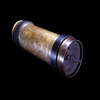

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This image shows a cylindrical object that appears to be a historic instrument or device. The object is mostly metallic with a brass-toned body and dark bands at each end. One end features a circular plate with a protruding component and various small parts, which might be controls or mechanisms for operation. This item resembles devices used in scientific or navigational contexts from the past.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averagin

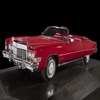

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit features a classic red convertible car, specifically a Cadillac Eldorado. The car is styled with chrome detailing, a prominent front grille, and signature Cadillac insignia. The interior features red leather seats, complementing the exterior. The design reflects a vintage aesthetic, typical of luxury American cars from the 1970s.
==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 198

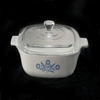

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This is a classic CorningWare dish from the "Cornflower" collection. CorningWare is a popular brand of cookware that gained prominence in the mid-20th century. The dishes, made from a unique glass-ceramic material, are known for their durability and versatility, being able to be used on the stovetop, oven, and even the freezer. The "Cornflower" pattern, with its simple blue floral design, was introduced in 1958 and became an iconic part of many American kitchens. Today, pieces like this are often seen as collectible items, appreciated for both their functionality and nostalgic value.
==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for milita

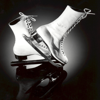

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit features a pair of white figure skates, laced up and mounted in a reflective black and white setting. The skates are positioned artistically with one slightly leaning on the other, highlighting their sleek design and glossy metal blades. The reflective surface adds depth, creating an elegant and timeless display, likely emphasizing the beauty and craftsmanship of the skates.
==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence ex

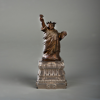

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a small-scale sculpture resembling the Statue of Liberty. The figure is depicted holding a torch in its right hand and a tablet in its left. The sculpture is set on a detailed pedestal, which mimics the traditional base of the actual Statue of Liberty. The sculpture appears to be made from a metal material, giving it a dark bronze appearance, while the pedestal looks silvery or metallic.
==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaig

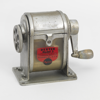

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This is a vintage manual pencil sharpener, the Dexter Model 3, made by Automatic Pencil Sharpener Company from Rockford, Illinois, USA. It has a metal body with a hand crank on the side for operating the sharpening mechanism. The sharpener can be mounted on a surface, indicated by the base with holes for screws. It features a dial with multiple holes to accommodate different pencil sizes. The label on the front provides the model and company information.
==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not curr

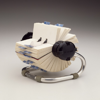

==> Original user question: What can you tell me about this exhibit?
==> OpenAI GPT-4o generated answer: This image shows a Rolodex, a rotating file device used to store business contact information. It was popular in offices before digital address books became commonplace. The device allowed users to keep cards alphabetically and flip through them to find business contacts easily. The exhibit reflects a piece of office history and technology from the pre-digital age, showcasing how people organized information manually.
==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easil

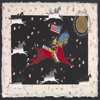

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This artwork features a native figure riding a red horse across a black background. The figure holds an American flag and is adorned with traditional regalia. Surrounding them are white horses galloping in various directions. A stylized sun or moon, represented by a gold circle with black rays, appears in the upper right. The background is dotted with abstract, leaf-like shapes. The piece is bordered by a textured, rough-edged frame in lighter tones with more leaf-like shapes. The style seems to incorporate elements of indigenous art and storytelling.
==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses

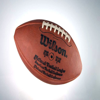

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The image shows an American football made by Wilson. It has the typical oval shape and brown leather surface with white laces on top. The logo and text include "Wilson," as well as references to the National Football League (NFL), American Football Conference, and National Football Conference. This football is likely an official NFL game ball.
==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable 

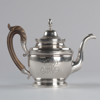

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This is a silver teapot with an ornate, classical design. It features a polished finish with a domed lid topped by a small finial. The body is engraved with elegant, cursive initials, adding a personalized touch. The spout is gracefully curved, and the handle appears to be made of wood or a similar material with a decorative flourish. The teapot rests on a slightly raised circular base, giving it an elegant stance. This piece likely reflects a period style, possibly from the 18th or 19th century.
==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed li

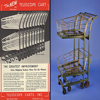

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit showcases an early shopping cart design known as the "Telescope Cart" by Telescope Carts, Inc., from Kansas City, Missouri. The display includes an advertisement highlighting its innovation with two wire baskets stacked vertically, allowing for efficient stacking and storage. The cart features a metal framework with wheels for mobility, emphasizing the convenience of putting shopping baskets on wheels, which was considered a significant improvement at the time.
==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of th

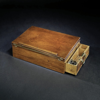

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a wooden writing box or chest, featuring a hinged lid and a pull-out drawer. The exterior appears to be crafted from polished wood, giving it a classic and elegant appearance. The drawer has compartments, likely used for storing writing materials such as ink and pens. The overall design suggests it was used for writing or correspondence, possibly serving as a portable desk.
==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document

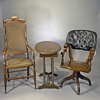

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit features three pieces of vintage furniture:

1. **Left Chair:** This is a high-backed wooden chair with a woven cane seat and back. The design is traditional, with turned legs and a decorative crest at the top.

2. **Center Table:** A small, round wooden table with a simple surface. The base has two intricately turned legs that end in a sturdy, flat. symmetrical design for stability.

3. **Right Chair:** An office armchair with a wooden frame and black leather upholstery. The seat is tufted for a classic, cushioned look. The chair has a swivel base with four legs, each ending in casters for mobility.

Overall, the pieces are examples of period furniture, showcasing craftsmanship and design characteristic of their era.
==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House o

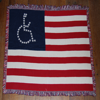

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This image shows a flag inspired by the design of the U.S. flag, featuring horizontal red and white stripes. The blue field in the upper left has been modified, replacing the traditional stars with an arrangement that forms the shape of a wheelchair symbol. This suggests a focus on disability awareness and advocacy, emphasizing inclusivity and representation. The flag also has fringed edges in red, white, and blue, adding a decorative element.
==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in D

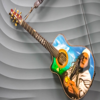

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit features an acoustic guitar mounted on a wall with a wavy, textured design. The guitar has a colorful, detailed airbrush painting on the body, depicting a person with a serene expression. The artwork includes vibrant hues of blue, green, and yellow. The headstock of the guitar has golden tuning pegs, and the neck has decorative inlays. The guitar is secured with a strap and appears to be part of a display or exhibition.
==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely wit

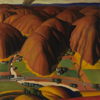

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The painting titled "Rolling Hills" by Ross Braught, created in 1932, depicts an expansive landscape view focusing on rolling hills and agricultural land. The hills are painted in earthy tones of brown and reddish hues, rising dramatically and dominating the composition. Between these natural formations are patches of farmland, distinguished by shades of green and yellow, illustrating cultivated fields. Scattered among the fields are small, simplistic depictions of buildings, possibly farmhouses, adding a human element to the largely natural scene. The bold use of color and geometric shapes emphasizes the undulating terrain of the landscape.
==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's 

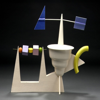

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: This exhibit is a sculpture composed of various geometric and abstract shapes. The structure includes a primary base with two triangular spikes. Several colorful elements are mounted on a horizontal rod, including spherical and rectangular forms. The right side features a white, funnel-like object with a curved yellow element attached. Above, there is a horizontal rod with blue triangular and rectangular shapes, giving it a kinetic feel similar to a mobile. The composition is modern and abstract, featuring a mix of materials and colors that create a dynamic and playful aesthetic.
==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, an

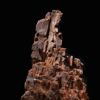

==> Original user question: Can you describe this exhibit?
==> OpenAI GPT-4o generated answer: The exhibit shown in the image appears to be a piece of petrified wood. Petrified wood forms when plant material is buried by sediment and protected from decay by oxygen and organisms, often over millions of years. Mineral-rich water flows through the sediments and replaces the original plant material with minerals, such as silica, resulting in a fossilized replica of the original wood. The exhibit displays a natural, rugged structure with fibrous textures and varying shades of brown, which are characteristic of petrified wood.
==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal confl

In [5]:
import my_utils_openai
# Perform inference on the test dataset using OpenAI API and save the results to a CSV file
my_utils_openai.inference_openai(base_model, processor, dataset['test'], './results/inference_results/inference_results_openai_gpt4o.csv')

## 2.5 Compare the Quality of Fine-Tuned Models with OpenAI GPT-4o

==> Plotting similarity scores...


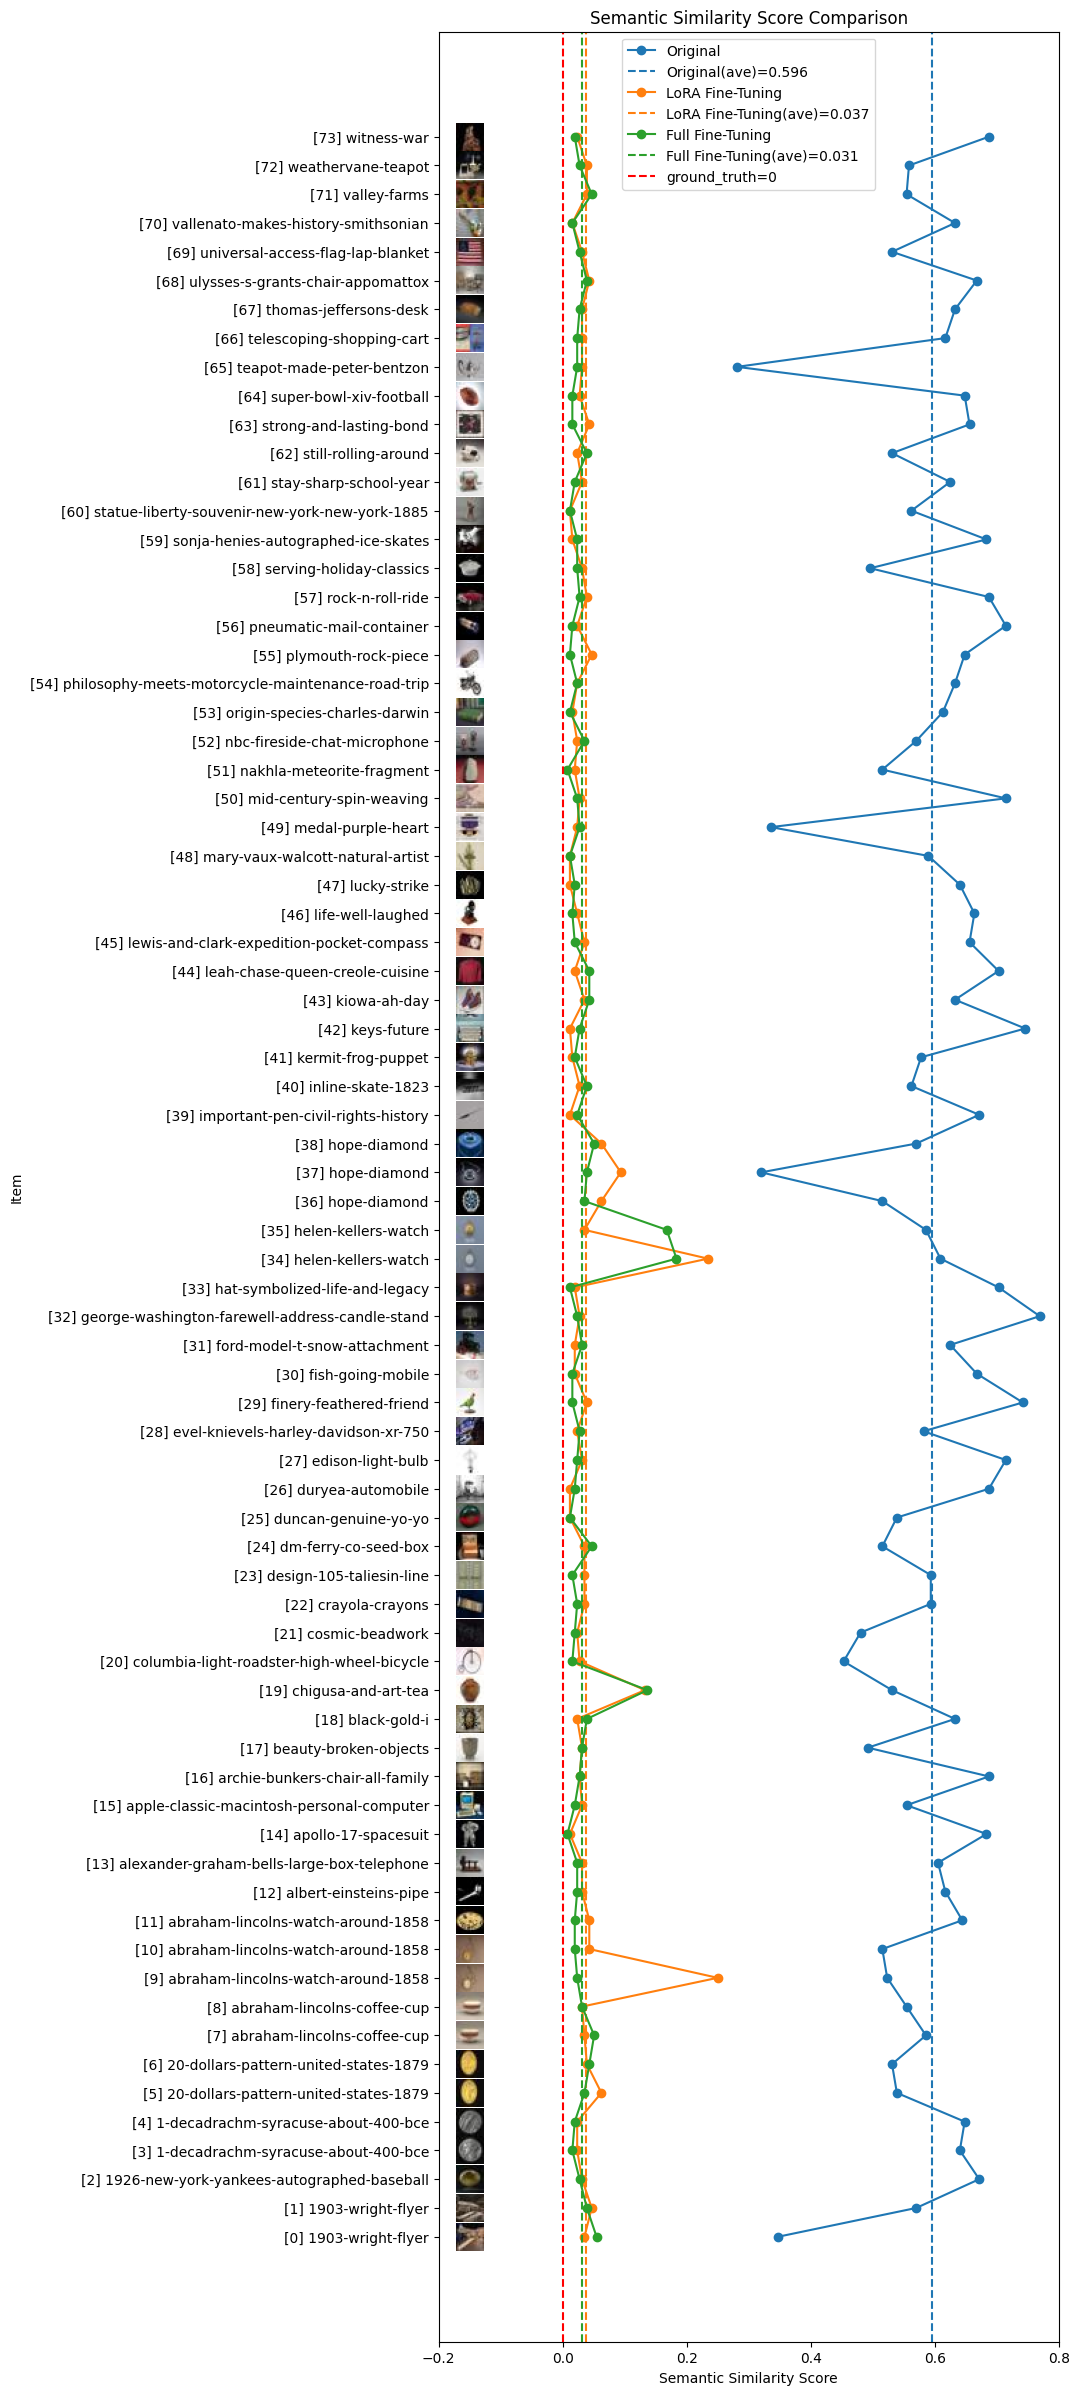

In [6]:
# Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
# Compare Base Model (No Fine-Tuning) vs. LoRA Fine-Tuning vs. Full Fine-Tuning
my_utils.plot_similarity_scores([('Original', './finetuned_inference_results/inference_results_before_finetuning.csv'),
                                 ('LoRA Fine-Tuning', './finetuned_inference_results/inference_results_after_lora_finetuning.csv'),
                                 ('Full Fine-Tuning', './finetuned_inference_results/inference_results_after_full_finetuning.csv')], 
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/finetuning_similarity_score_comparison.jpg')

==> Plotting similarity scores...


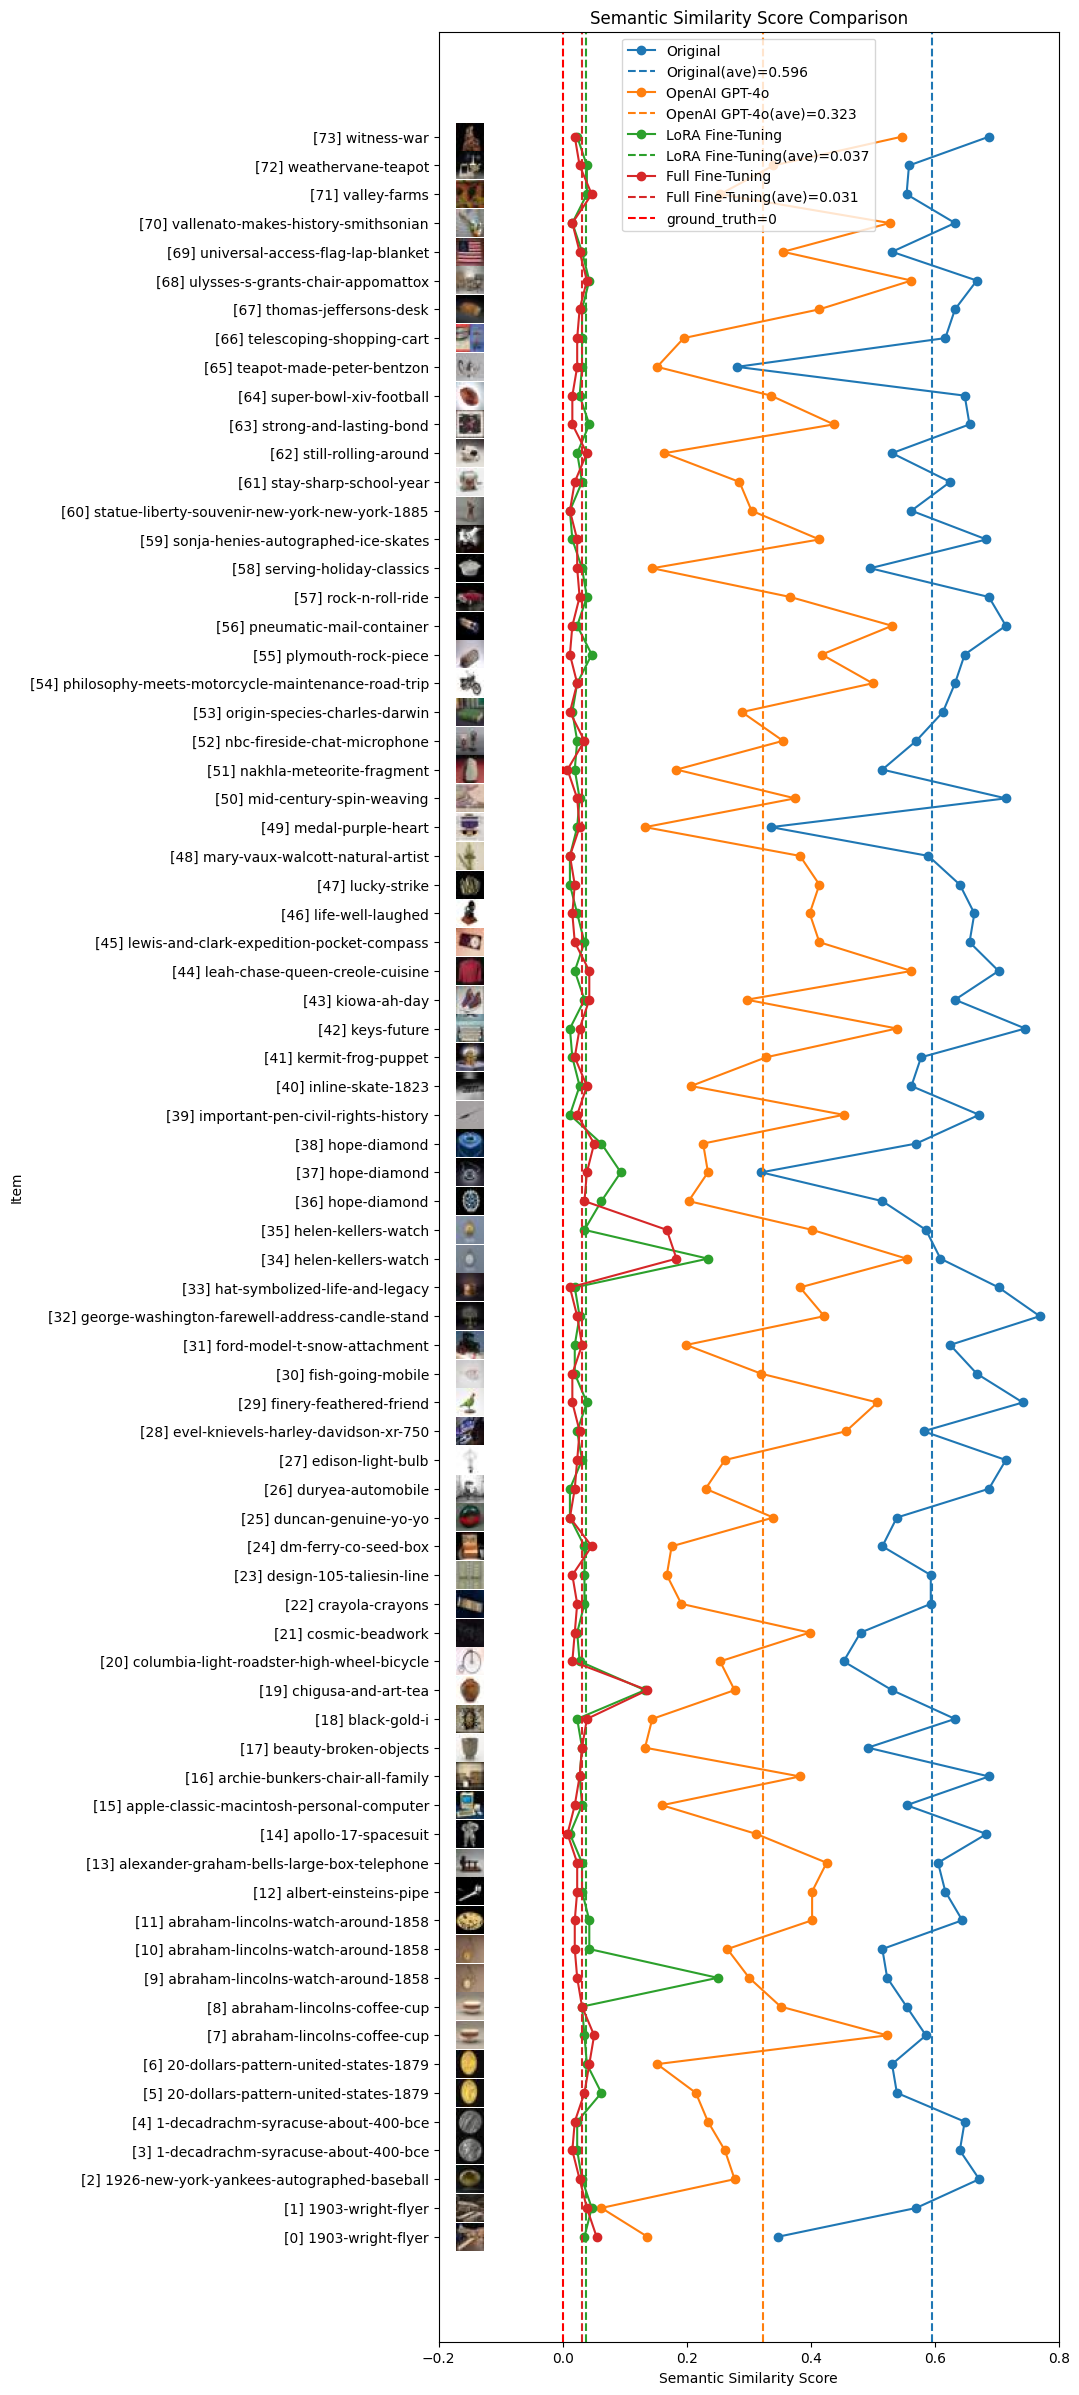

In [7]:
# Compare Base Model (No Fine-Tuning) vs. LoRA Fine-Tuning vs. Full Fine-Tuning vs. OpenAI GPT-4o
my_utils.plot_similarity_scores([('Original', './finetuned_inference_results/inference_results_before_finetuning.csv'),
                                 ('OpenAI GPT-4o', './results/inference_results/inference_results_openai_gpt4o.csv'),
                                 ('LoRA Fine-Tuning', './finetuned_inference_results/inference_results_after_lora_finetuning.csv'),
                                 ('Full Fine-Tuning', './finetuned_inference_results/inference_results_after_full_finetuning.csv')], 
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_score_comparison.jpg')